In [22]:
import os
from pathlib import Path

import cv2 as cv
import matplotlib
import numpy as np
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

from utils.general import integral_intensity_projection
from utils.preprocess import rotate_point
from utils.shortcut import get_fake_result
from utils.yolo import get_teeth_ROI

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

% matplotlib inline


In [23]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/phase-2')

In [24]:
plt.gray()

image_paths = list(data_dir.glob('00008026.jpg'))
image_paths[0].name


'00008026.jpg'

<Figure size 432x288 with 0 Axes>

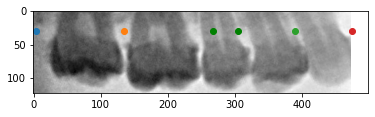

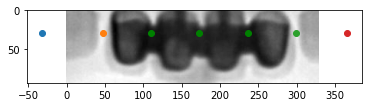

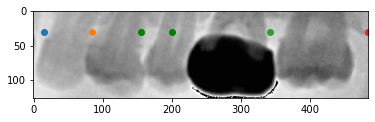

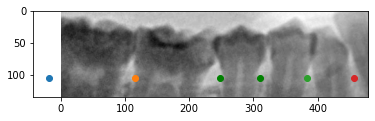

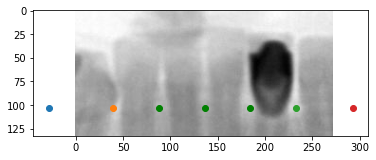

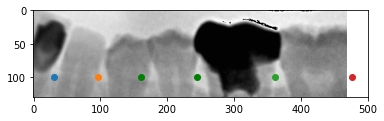

In [132]:
from utils.general import intersection
from utils.edge import fill_rotate, get_rotation_angle, gum_jaw_separation


class ImageEdge:
    tooth_number_dict = {
        'upper': {
            'left': ['17', '13'],
            'right': ['23', '27'],
            'middle': []
        },
        'lower': {
            'left': ['47', '43'],
            'right': ['33', '37'],
            'middle': []
        },
    }

    zooming_margin = 30

    def __init__(self, image_path, model=None):
        self.im_global = cv.imread(str(image_path), cv.IMREAD_GRAYSCALE)

        self.image_path = image_path
        self.filename = image_path.stem

        # Set up roi
        if model:
            results = model(self.image_path)
        else:
            results = get_fake_result(self.image_path)

        self.template_points = {
            'upper': [],
            'lower': []
        }

        teeth_roi = get_teeth_ROI(results)
        self.teeth_roi_images = teeth_roi['images'][self.filename]
        self.split_teeth = teeth_roi['split_teeth'][self.filename]

        for split_tooth in self.split_teeth.values():
            split_tooth['crop_image'] = cv.cvtColor(split_tooth['crop_image'], cv.COLOR_RGBA2GRAY)
            split_tooth['xyxy'] = split_tooth['xyxy'].int().numpy().squeeze()

        self.set_up_roi()

    def set_up_roi(self):
        for target_roi in self.teeth_roi_images:
            target_roi['image'] = cv.cvtColor(target_roi['image'], cv.COLOR_RGBA2GRAY)

            flag = target_roi['flag']
            tooth_position = target_roi['tooth_position']
            source = target_roi['image']

            theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
            source_rotated = fill_rotate(self.im_global, target_roi['xyxy'], theta)

            target_roi['image_rotated'] = source_rotated

            gum_sep_line, jaw_sep_line, hor_valleys, hor = gum_jaw_separation(source_rotated, flag=flag, margin=0)

            if flag == 'upper':
                y1 = gum_sep_line - self.zooming_margin
                y2 = jaw_sep_line
            else:
                y1 = jaw_sep_line
                y2 = gum_sep_line + self.zooming_margin

            gum_rotated_matrix = np.array([[0, gum_sep_line],
                                           [100, gum_sep_line]])

            target_roi['image_zooming'] = source_rotated[y1:y2, :]
            target_roi['image_zooming_xyxy'] = np.array([])

            target_roi['gum_sep_line'] = gum_sep_line
            target_roi['jaw_sep_line'] = jaw_sep_line
            target_roi['angle'] = theta

            # Get gum line global
            gum_sep_line_global = rotate_point(theta, target_roi['image'].shape, gum_rotated_matrix, recovery=True)
            gum_sep_line_global = gum_sep_line_global + target_roi['xyxy'].numpy()[:2]
            target_roi['gum_sep_line_global'] = gum_sep_line_global

            # Split teeth set up
            # number = self.tooth_number_dict[flag][tooth_position][0]
            for number in self.tooth_number_dict[flag][tooth_position]:
                split_tooth = self.split_teeth[number]
                init_gap = self.find_global_gap_by_tooth(split_tooth['crop_image'], split_tooth['xyxy'], theta,
                                                         gum_sep_line_global)

                self.template_points[flag].append(init_gap)

        for flag in ('upper', 'lower'):
            points = self.template_points[flag]
            points = np.vstack(points)
            points = points[np.argsort(points[:, 0])]

            self.template_points[flag] = points

    @staticmethod
    def find_local_gap_by_tooth(im_tooth):
        """
        This function finds the local minima of an image of a tooth.
        Args:
            im_tooth: A 2-D array representing an image of a tooth

        Returns:
            gaps: The location of the local minima in an array
            gaps_intensity: The intensity of the local minima in the image
        """
        # Get the height and width of the tooth
        h, w = im_tooth.shape

        # Get the integral intensity projection of the tooth
        hor, ver = integral_intensity_projection(im_tooth)

        # Get the inverse of the ver projection
        ver_inverse = ver.max() - ver

        # Find the peaks of the ver_inverse
        peaks, properties = find_peaks(ver_inverse, height=0)

        # Get the peaks from left and right
        peaks_left = peaks[peaks < w / 2]
        peaks_right = peaks[peaks > w / 2]

        # Get the local minima from the left and right peaks
        gaps = np.array((peaks_left[ver[peaks_left].argmin()], peaks_right[ver[peaks_right].argmin()]))
        gaps_intensity = ver[gaps]

        gap_lines = []
        for gap in gaps:
            gap_lines.append([gap, 0])
            gap_lines.append([gap, 100])
        gap_lines = np.array(gap_lines)

        return gaps, gap_lines, gaps_intensity

    def find_global_gap_by_tooth(self, tooth_im, tooth_xyxy, theta, gum_sep_line_global):
        # Find gap beside tooth
        tooth_im_rotated = fill_rotate(self.im_global, tooth_xyxy, theta)
        gaps_r, gap_lines_r, gaps_intensity_r = self.find_local_gap_by_tooth(tooth_im_rotated)
        gaps_o, gap_lines_o, gaps_intensity_o = self.find_local_gap_by_tooth(tooth_im)

        # Get gap line global
        gap_line_matrix_r = rotate_point(theta, tooth_im_rotated.shape, gap_lines_r, recovery=True)
        gap_line_matrix_r = gap_line_matrix_r + tooth_xyxy[:2]

        gap_line_matrix_o = gap_lines_o + tooth_xyxy[:2]

        gap_line_matrix = gap_line_matrix_r.copy()
        left_gap_flag = gaps_intensity_r[0] < gaps_intensity_o[0]
        right_gap_flag = gaps_intensity_r[1] < gaps_intensity_o[1]
        gap_line_matrix[:2] = gap_line_matrix_r[:2] if left_gap_flag else gap_line_matrix_o[:2]
        gap_line_matrix[2:] = gap_line_matrix_r[2:] if right_gap_flag else gap_line_matrix_o[2:]

        point1 = intersection(*gap_line_matrix[:2], *gum_sep_line_global)
        point2 = intersection(*gap_line_matrix[2:], *gum_sep_line_global)

        gaps_global = np.array([point1,
                                point2])

        # Plot
        # plt.gray()
        # plt.imshow(1 - self.im_global)
        # plt.axline(*gap_line_matrix[:2])
        # plt.axline(*gap_line_matrix[2:])
        # plt.scatter(*point1)
        # plt.scatter(*point2)
        # plt.show()

        return gaps_global

    def find_gap_in_roi(self):
        for target_roi in self.teeth_roi_images:
            flag = target_roi['flag']
            tooth_position = target_roi['tooth_position']
            xyxy = target_roi['xyxy'].numpy()
            init_gap = self.template_points[flag]

            # Select gap in roi
            ge = init_gap >= xyxy[:2]
            le = init_gap <= xyxy[2:]

            t = np.where(np.all(ge, axis=1) & np.all(le, axis=1))[0]
            init_gap_index = np.array([t[0] - 1, t[0], t[1], t[1] + 1])

            # Change gap's axis to zooming roi
            init_gap = init_gap[init_gap_index]
            init_gap -= xyxy[:2]

            init_gap = rotate_point(target_roi['angle'], target_roi['image'].shape, init_gap)

            if flag == 'upper':
                margin_line = self.zooming_margin
                offset = target_roi['gum_sep_line'] - self.zooming_margin
            else:
                h, _ = target_roi['image_zooming'].shape
                margin_line = h - self.zooming_margin
                offset = target_roi['jaw_sep_line']

            init_gap[:, 1] = [margin_line] * init_gap[:, 1].shape[0]

            # Calc new gap

            if tooth_position != 'middle':
                # Add factor here
                left_size = (init_gap[1] - init_gap[0])
                right_size = (init_gap[3] - init_gap[2])

                point1 = init_gap[1] + left_size
                point2 = init_gap[2] - right_size

                gaps = np.array([point1, point2])

            else:
                tooth_step = (init_gap[2] - init_gap[1]) / 4
                gaps = np.array([init_gap[1] + tooth_step * i for i in range(1, 4)])

            # Transform back to global
            gaps_global = gaps.copy()
            gaps_global += [0, offset]
            gaps_global = rotate_point(target_roi['angle'], target_roi['image'].shape, gaps_global, recovery=True)
            gaps_global += xyxy[:2]

            self.template_points[flag] = np.concatenate((self.template_points[flag], gaps_global), axis=0)

            plt.imshow(1 - target_roi['image_zooming'])
            for i in init_gap:
                plt.scatter(*i)
            for i in gaps:
                plt.scatter(*i, color='green')
            plt.show()

            # break

a = ImageEdge(image_paths[0])
# a.split_teeth['13'].keys()
a.find_gap_in_roi()


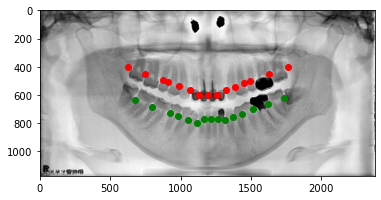

In [133]:
b = a.template_points['upper']


plt.imshow(1 - a.im_global)
for i in a.template_points['upper']:
    plt.scatter(*i, color='red')
for i in a.template_points['lower']:
    plt.scatter(*i, color='green')
plt.show()
